<a href="https://colab.research.google.com/github/Rickmwasofficial/crop-disease/blob/master/training/Crop_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Crop disease classification

**Problem Definition**

The task here is to train a model that is capable of identifying crop diseases frop images of plant leaves. This is a supervised task since we have labelled data and it is a multi-class classification problem.

1. Data
> We are using the [plantvillage dataset](https://www.kaggle.com/api/v1/datasets/download/abdallahalidev/plantvillage-dataset)
>
 The data is unstructured since we are working with images hence naturally we result to using a DL model for training.

 The dataset has images foll different types of plants, but for our initial stage will we use only the corn/Maize dataset.

2. Evaluation

  Success for us would mean getting highaccuracy scores of above 80%

3. Features
  
  The maize dataset has for different types of categories, i.e healthy, cercospora leaf spot gray leaf spot, northern leaf blight and common rust.

4. Modelling
  
  Based on our problem and data we are going, to train four different models experimentally.

  

*   *Model 1*:
>   The first step is to train a feature extraction model (without unfreezing layers) on the maize dataset without data augmentation.
*   *Model 2*:
>   The second step is to train a feature extraction model on the maize dataset but this time implementing data augmentation
*   *Model 3*:
>   The third step is fine tuning the feature extraction model by training it on the maize dataset without data augmentation
*   *Model 4*:
>   The last step is to fine tune the feature extraction model by taining it on the maize dataset but this time with data augmentation

  Then we shall pick the best performing model



In [ ]:
# Downloading dataset

import os
import requests
import zipfile
from pathlib import Path

def download_dataset(url, save_dir):
    """
    Download and extract dataset
    """
    # Create directory if it doesn't exist
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Download file
    response = requests.get(url, stream=True)
    zip_path = save_dir / "dataset.zip"

    print("Download started!!!")
    # Save downloaded file
    with open(zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("completed!!!")
    # Extract files
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
       zip_ref.extractall(save_dir)

    # Remove zip file
    # zip_path.unlink()

# Example usage
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/abdallahalidev/plantvillage-dataset"  # Replace with actual dataset URL
save_directory = "plant_disease"
download_dataset(dataset_url, save_directory)

Download started!!!
completed!!!


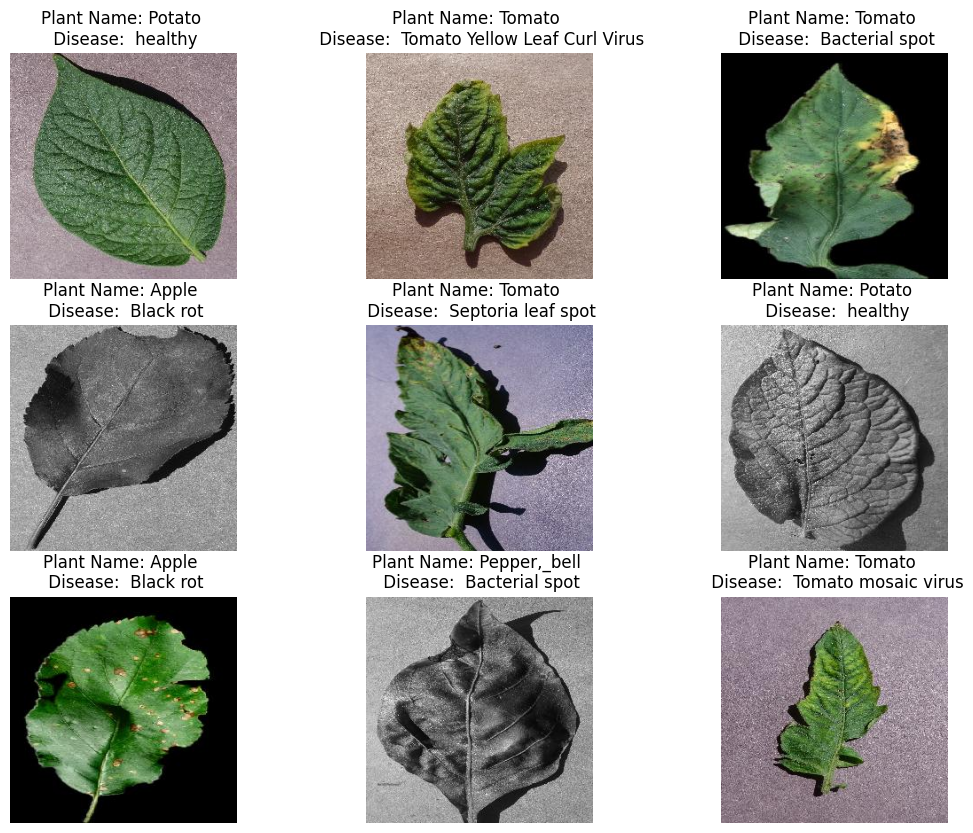

In [ ]:
# Visualizing images
import random
import matplotlib.pyplot as plt

og_path = "/content/plant_disease/plantvillage dataset/"

def visualize_images(og_path):
  """
  The function receives a path to the directory where images are stored and visualizes them randomly
  """
  plt.figure(figsize=(13, 10))
  for i in range(9):
    plt.subplot(3, 3, i+1)
    img_path = os.path.join(og_path, random.choice(os.listdir(og_path)))
    img_type = random.choice(os.listdir(img_path))
    img = plt.imread(os.path.join(img_path, img_type, random.choice(os.listdir(os.path.join(img_path, img_type)))))
    plt.imshow(img)
    plt.axis('off')
    details = img_type.split('__')
    plt.title(f"Plant Name: {details[0]} \n Disease: {' '.join(details[1].split('_'))}")

visualize_images(og_path)

In [ ]:
import os
import shutil
import random
from pathlib import Path

def merge_and_split_folders(source_path, plant_name, train_ratio=0.8, destination_path=None):
    """
    Merges folders from different image types and splits into train/test sets.

    Args:
        source_path (str): Path to the plant_village_dataset directory
        plant_name (str): Name of the plant to process (e.g., 'Tomato', 'Potato')
        train_ratio (float): Ratio of images to use for training (default: 0.8)
        destination_path (str, optional): Path where the merged folders will be created.

    Returns:
        str: Path to the created merged directory
    """
    # Convert to Path objects
    source_path = Path(source_path)
    if destination_path is None:
        destination_path = Path(plant_name)
    else:
        destination_path = Path(destination_path)

    # Create train and test directories
    train_path = destination_path / 'train'
    test_path = destination_path / 'test'
    train_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    # Image type directories to process
    image_types = ['color', 'grayscale', 'segmented']

    # Dictionary to collect all files per condition before splitting
    condition_files = {}

    # First pass: Collect all files per condition
    for img_type in image_types:
        img_type_path = source_path / img_type

        if not img_type_path.exists():
            print(f"Warning: {img_type} directory not found in {source_path}")
            continue

        # Find all directories for the specified plant
        plant_dirs = [d for d in img_type_path.iterdir() if d.is_dir() and plant_name.lower() in d.name.lower()]

        for plant_dir in plant_dirs:
            # Extract condition from directory name
            condition = plant_dir.name.lower().replace(plant_name.lower(), '').strip()
            if not condition:
                condition = 'healthy'

            # Initialize condition in dictionary if not exists
            if condition not in condition_files:
                condition_files[condition] = []

            # Collect all image files
            for img_file in plant_dir.glob('*'):
                if img_file.is_file() and img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    new_filename = f"{img_type}_{img_file.name}"
                    condition_files[condition].append((img_file, new_filename))

    # Second pass: Split and copy files
    total_files = 0
    for condition, files in condition_files.items():
        # Create condition directories in both train and test
        train_condition_path = train_path / condition
        test_condition_path = test_path / condition
        train_condition_path.mkdir(exist_ok=True)
        test_condition_path.mkdir(exist_ok=True)

        # Shuffle files for random split
        random.shuffle(files)

        # Calculate split point
        split_idx = int(len(files) * train_ratio)
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        # Copy train files
        for src_file, new_filename in train_files:
            shutil.copy2(
                src_file,
                train_condition_path / new_filename
            )

        # Copy test files
        for src_file, new_filename in test_files:
            shutil.copy2(
                src_file,
                test_condition_path / new_filename
            )

        print(f"\nCondition: {condition}")
        print(f"Training files: {len(train_files)}")
        print(f"Testing files: {len(test_files)}")
        total_files += len(files)

    print(f"\nMerge and split complete!")
    print(f"Total files processed: {total_files}")
    print(f"Output directory: {destination_path.absolute()}")

    return str(destination_path.absolute())

# Example usage
if __name__ == "__main__":
    # Example paths - adjust these to match your actual directory structure
    dataset_path = "plant_disease/plantvillage dataset"
    plant_name = "Corn"
    merged_path = merge_and_split_folders(dataset_path, plant_name)


Condition: _(maize)___northern_leaf_blight
Training files: 2364
Testing files: 591

Condition: _(maize)___cercospora_leaf_spot gray_leaf_spot
Training files: 1231
Testing files: 308

Condition: _(maize)___healthy
Training files: 2788
Testing files: 698

Condition: _(maize)___common_rust_
Training files: 2860
Testing files: 716

Merge and split complete!
Total files processed: 11556
Output directory: /content/Corn


In [ ]:
os.listdir('/content/Corn')

['train', 'test']

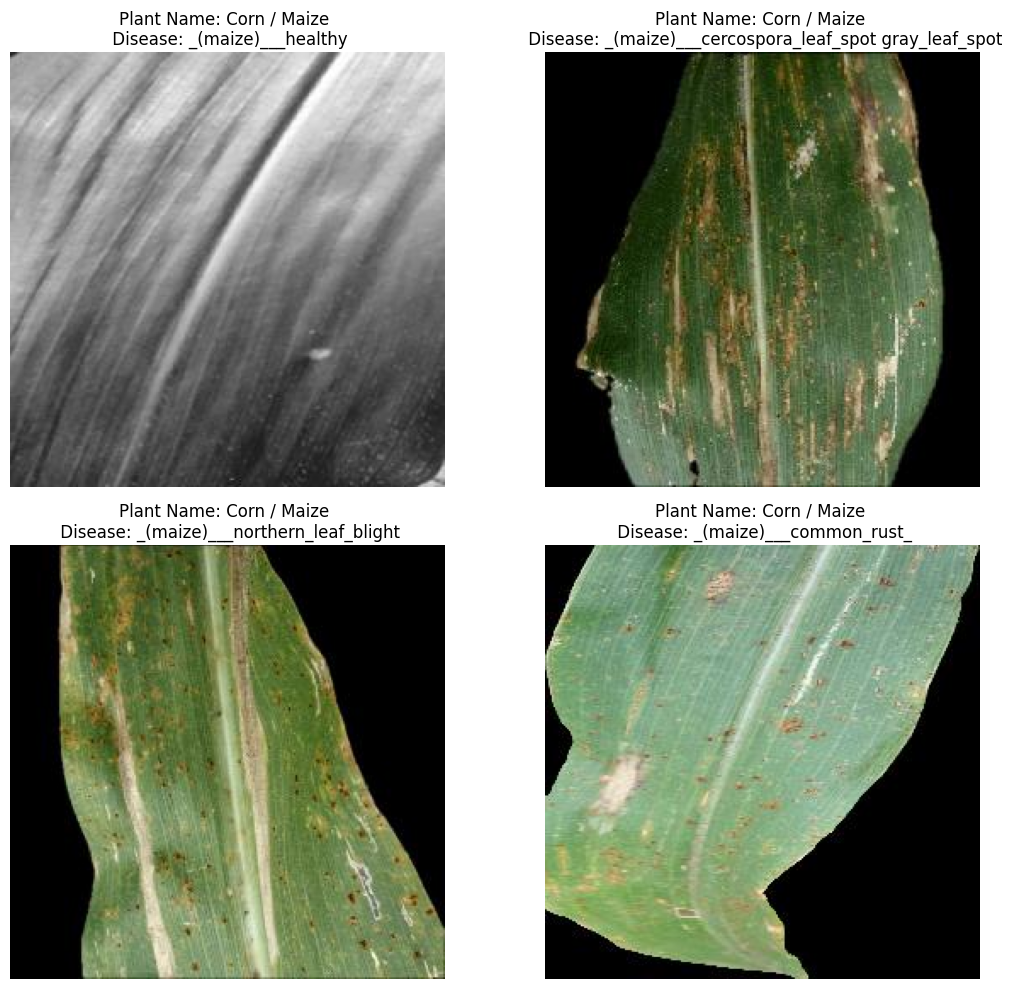

In [ ]:
# Visualizing our corn dataset
og_path = "/content/Corn/train/"

def visualize_images(og_path):
  """
  The function receives a path to the directory where images are stored and visualizes them randomly
  """
  plt.figure(figsize=(13, 10))
  for i in range(4):
    plt.subplot(2, 2, i+1)
    disease = random.choice(os.listdir(og_path))
    img_path = os.path.join(og_path, disease)
    img_type = random.choice(os.listdir(img_path))
    img = plt.imread(os.path.join(img_path, img_type))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.title(f"Plant Name: Corn / Maize \n Disease: {disease}")

visualize_images(og_path)

## Load the dataset into tensors

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

train_dir = '/content/Corn/train/'
test_dir = '/content/Corn/test/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

Found 9243 files belonging to 4 classes.
Found 2313 files belonging to 4 classes.


In [ ]:
train_data.class_names

['_(maize)___cercospora_leaf_spot gray_leaf_spot',
 '_(maize)___common_rust_',
 '_(maize)___healthy',
 '_(maize)___northern_leaf_blight']

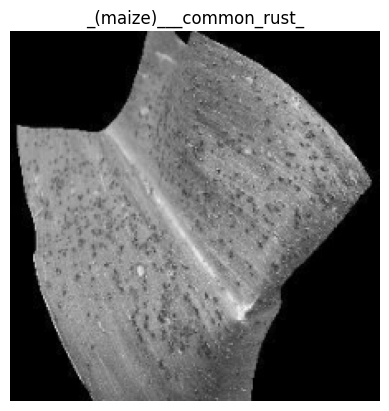

In [ ]:
for image_batch, label_batch in train_data.take(1):
  img = image_batch[1]/255.0
  plt.imshow(np.squeeze(img))
  plt.axis('off')
  plt.title(train_data.class_names[np.argmax(label_batch[1].numpy())])

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

base_model = EfficientNetV2B0(
    input_shape = (224, 224, 3),
    include_top = False
)

base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='Input Layer')

x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name='GAP_layer')(x)

outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    loss = CategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GAP_layer (GlobalAveragePooling2D)   │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
history = model.fit(
    train_data,
    epochs = 5,
    # steps_per_epoch = len(train_data) - 1,
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data))
)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.8374 - loss: 0.4768 - val_accuracy: 0.9271 - val_loss: 0.1806
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.9427 - loss: 0.1576 - val_accuracy: 0.9497 - val_loss: 0.1301
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9537 - loss: 0.1282 - val_accuracy: 0.9497 - val_loss: 0.1119
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9607 - loss: 0.1134 - val_accuracy: 0.9601 - val_loss: 0.1145
Epoch 5/5
288/289 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9622 - loss: 0.1054

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


289/289 ━━━━━━━━━━━━━━━━━━━━ 59s 180ms/step - accuracy: 0.9622 - loss: 0.1053 - val_accuracy: 0.8889 - val_loss: 0.2222


In [ ]:
!wget https://raw.githubusercontent.com/Rickmwasofficial/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import plot_loss_curves, compare_historys

--2024-11-15 23:50:34--  https://raw.githubusercontent.com/Rickmwasofficial/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-15 23:50:34 (85.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
model.evaluate(test_data)

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9560 - loss: 0.1067


[0.10594919323921204, 0.957198441028595]

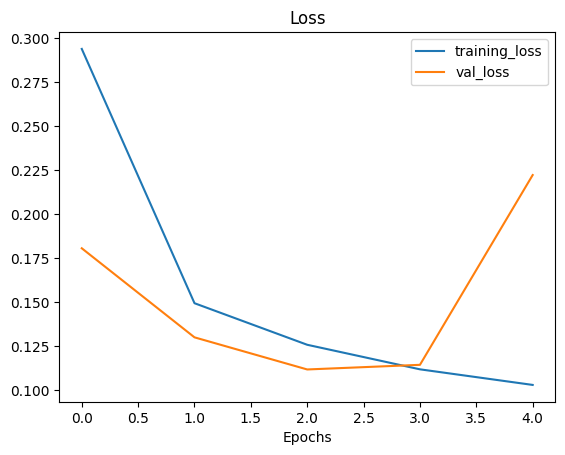

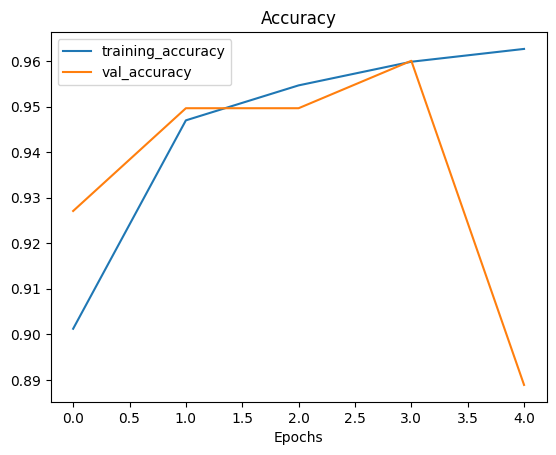

In [ ]:
plot_loss_curves(history)

(-0.5, 223.5, 223.5, -0.5)

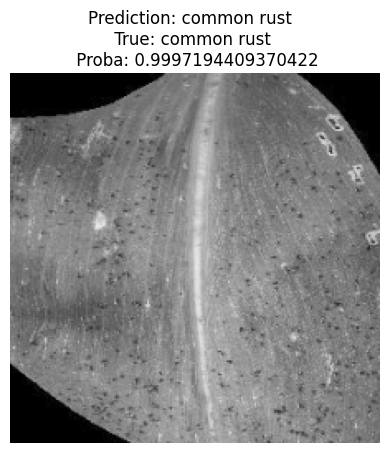

In [ ]:
img_path = '/content/Corn/test/'
img_type = random.choice(os.listdir(img_path))
new_img = os.path.join(img_path, img_type)
img = os.path.join(new_img, random.choice(os.listdir(new_img)))
img = tf.io.read_file(img)

# Decode the image into a tensor
img = tf.image.decode_image(img, channels=3)  # Ensure 3 channels (RGB)

# Resize the image to the expected input shape
img = tf.image.resize(img, size=[224, 224])

# Rescale the image to [0, 1]
img_1 = img / 255.0

# Expand dimensions to fit model input
img = tf.expand_dims(img, axis=0)

# Make prediction
preds = model.predict(img, verbose=0)

# Print predictions for debugging
# print("Predictions:", preds)

# Get the class index with the highest probability
predicted_class_index = tf.argmax(preds[0])

plt.title(f"Prediction: {' '.join(train_data.class_names[predicted_class_index].split('___')[1].split('_'))} \n True: {' '.join(img_type.split('___')[1].split('_'))} \n Proba: {preds[0][tf.argmax(preds[0])]}")
plt.imshow(img_1)
plt.axis('off')

In [ ]:
save_pth = '/content/drive/MyDrive/Crop Disease'
model.save(f'{save_pth}/crop_disease_efficientnet_V1.keras')

#### We have finished the first training, the model is performing well but it seem like it is overfitting, so now we wil try and implement data augmentation to solve this issue

In [ ]:
# Load dataset into tensors

import tensorflow as tf
import pandas as pd
import numpy as np

train_dir = '/content/Corn/train/'
test_dir = '/content/Corn/test/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

Found 9243 files belonging to 4 classes.
Found 2313 files belonging to 4 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
])

In [ ]:
base_model = EfficientNetV2B0(
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='Input Layer')

x = data_augmentation(inputs)

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D(name='GAP_layer')(x)

outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss = CategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']

)

model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GAP_layer (GlobalAveragePooling2D)   │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
hist_2 = model_2.fit(
    train_data,
    epochs = 5,
    # steps_per_epoch = len(train_data) - 1,
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data))
)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - accuracy: 0.8379 - loss: 0.4790 - val_accuracy: 0.9375 - val_loss: 0.1911
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.9437 - loss: 0.1636 - val_accuracy: 0.9479 - val_loss: 0.1327
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9492 - loss: 0.1328 - val_accuracy: 0.9549 - val_loss: 0.1287
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9544 - loss: 0.1194 - val_accuracy: 0.9566 - val_loss: 0.1089
Epoch 5/5
288/289 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9571 - loss: 0.1074

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


289/289 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.9571 - loss: 0.1073 - val_accuracy: 1.0000 - val_loss: 0.0611


In [ ]:
model_2.evaluate(test_data)

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9597 - loss: 0.1102


[0.10582559555768967, 0.9589278101921082]

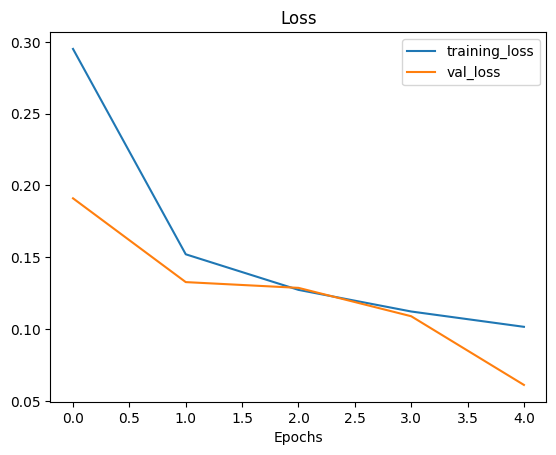

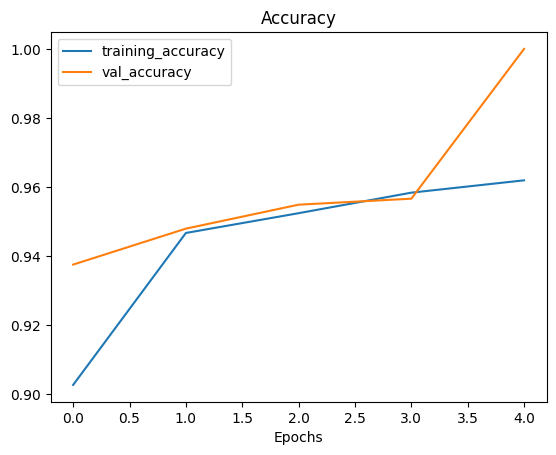

In [ ]:
plot_loss_curves(hist_2)

#### The model seems to be learning much better with data augmentation

(-0.5, 223.5, 223.5, -0.5)

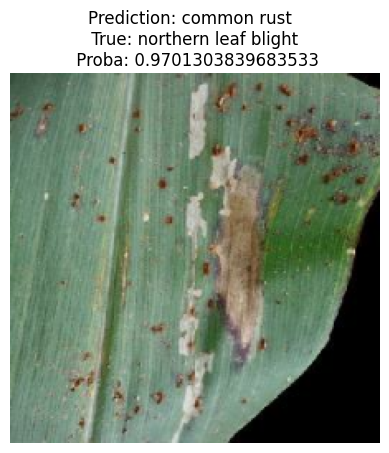

In [ ]:
img_path = '/content/Corn/test/'
img_type = random.choice(os.listdir(img_path))
new_img = os.path.join(img_path, img_type)
img = os.path.join(new_img, random.choice(os.listdir(new_img)))
img = tf.io.read_file(img)

# Decode the image into a tensor
img = tf.image.decode_image(img, channels=3)  # Ensure 3 channels (RGB)

# Resize the image to the expected input shape
img = tf.image.resize(img, size=[224, 224])

# Rescale the image to [0, 1]
img_1 = img / 255.0

# Expand dimensions to fit model input
img = tf.expand_dims(img, axis=0)

# Make prediction
preds = model_2.predict(img, verbose=0)

# Print predictions for debugging
# print("Predictions:", preds)

# Get the class index with the highest probability
predicted_class_index = tf.argmax(preds[0])

plt.title(f"Prediction: {' '.join(train_data.class_names[predicted_class_index].split('___')[1].split('_'))} \n True: {' '.join(img_type.split('___')[1].split('_'))} \n Proba: {preds[0][tf.argmax(preds[0])]}")
plt.imshow(img_1)
plt.axis('off')

In [ ]:
model.save(f'{save_pth}/crop_disease_efficientnet_V2.keras')

## Now we try fine-tuning the two feature extraction models to see if we can get just a little higher accuracy from them

1. Fine tuning without data augmentation

In [ ]:
# Load dataset into tensors

import tensorflow as tf
import pandas as pd
import numpy as np

train_dir = '/content/Corn/train/'
test_dir = '/content/Corn/test/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

Found 9243 files belonging to 4 classes.
Found 2313 files belonging to 4 classes.


In [ ]:
base_model = EfficientNetV2B0(
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = True

# Unfreeze the last ten layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name='GAP_layer')(x)

outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss = CategoricalCrossentropy(),
    optimizer = Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)
model_3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GAP_layer (GlobalAveragePooling2D)   │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 586,804 (2.24 MB)

 Non-trainable params: 5,337,632 (20.36 MB)

In [ ]:
for idx, layer in enumerate(base_model.layers):
  print(f'{idx}: {layer.name}, {layer.trainable}')

0: input_layer_6, False
1: rescaling_5, False
2: normalization_5, False
3: stem_conv, False
4: stem_bn, False
5: stem_activation, False
6: block1a_project_conv, False
7: block1a_project_bn, False
8: block1a_project_activation, False
9: block2a_expand_conv, False
10: block2a_expand_bn, False
11: block2a_expand_activation, False
12: block2a_project_conv, False
13: block2a_project_bn, False
14: block2b_expand_conv, False
15: block2b_expand_bn, False
16: block2b_expand_activation, False
17: block2b_project_conv, False
18: block2b_project_bn, False
19: block2b_drop, False
20: block2b_add, False
21: block3a_expand_conv, False
22: block3a_expand_bn, False
23: block3a_expand_activation, False
24: block3a_project_conv, False
25: block3a_project_bn, False
26: block3b_expand_conv, False
27: block3b_expand_bn, False
28: block3b_expand_activation, False
29: block3b_project_conv, False
30: block3b_project_bn, False
31: block3b_drop, False
32: block3b_add, False
33: block4a_expand_conv, False
34: blo

In [ ]:
hist_3 = model_3.fit(
    train_data,
    epochs = 20,
    validation_data = test_data,
    validation_steps = int(0.25 * len(train_data)),
    initial_epoch = len(history.history['loss'])- 1
)

Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 60s 119ms/step - accuracy: 0.7519 - loss: 0.7191 - val_accuracy: 0.9405 - val_loss: 0.1936
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 76s 145ms/step - accuracy: 0.9366 - loss: 0.2033 - val_accuracy: 1.0000 - val_loss: 0.1266
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - accuracy: 0.9521 - loss: 0.1458 - val_accuracy: 0.9627 - val_loss: 0.1120
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9619 - loss: 0.1150 - val_accuracy: 1.0000 - val_loss: 0.0426
Epoch 9/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.9678 - loss: 0.0995 - val_accuracy: 0.9666 - val_loss: 0.0843
Epoch 10/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9743 - loss: 0.0825 - val_accuracy: 0.8889 - val_loss: 0.0887
Epoch 11/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9768 - loss: 0.0703 - val_accuracy: 0.9718 - val_loss: 0.0703
Epoch 12/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9806 - loss: 0.06

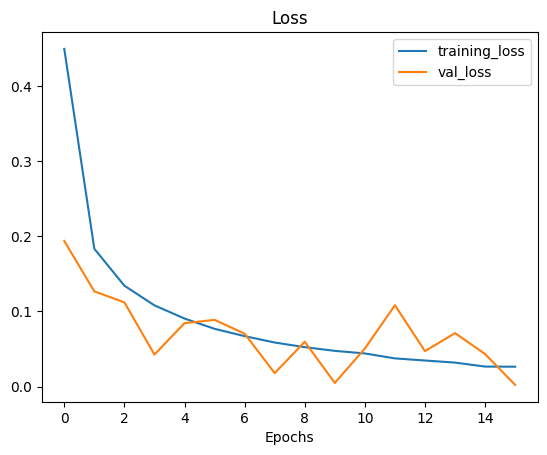

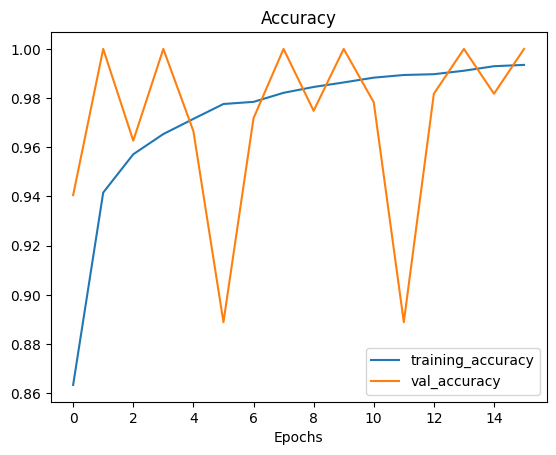

In [ ]:
plot_loss_curves(hist_3)

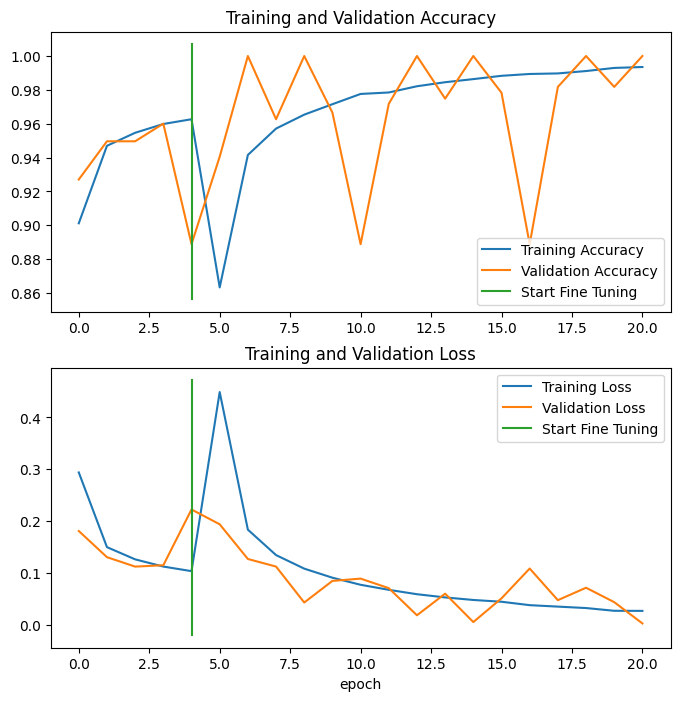

In [ ]:
compare_historys(history, hist_3)

In [ ]:
model_3.evaluate(test_data)

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9796 - loss: 0.0489


[0.04124554619193077, 0.9822741150856018]

In [ ]:
model.save(f'{save_pth}/crop_disease_efficientnet_finetuned_V1.keras')

# Fine tune with data augmentation

As you can see the fine tuned model has a higher accuracy and lower loss, let try and implement data augmentation

In [ ]:
# Load dataset into tensors

import tensorflow as tf
import pandas as pd
import numpy as np

train_dir = '/content/Corn/train/'
test_dir = '/content/Corn/test/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

Found 9243 files belonging to 4 classes.
Found 2313 files belonging to 4 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
])

In [ ]:
base_model = EfficientNetV2B0(
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = True

# Unfreeze the last ten layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='GAP_layer')(x)

outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(
    loss = CategoricalCrossentropy(),
    optimizer = Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)
model_4.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GAP_layer (GlobalAveragePooling2D)   │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 586,804 (2.24 MB)

 Non-trainable params: 5,337,632 (20.36 MB)

In [ ]:
hist_4 = model_4.fit(
    train_data,
    epochs = 13,
    validation_data = test_data,
    validation_steps = int(0.25 * len(train_data)),
    initial_epoch = len(hist_2.history['loss'])- 1
)

Epoch 5/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 52s 124ms/step - accuracy: 0.7125 - loss: 0.8116 - val_accuracy: 0.9180 - val_loss: 0.2819
Epoch 6/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.9048 - loss: 0.2945 - val_accuracy: 0.8889 - val_loss: 0.2255
Epoch 7/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9277 - loss: 0.2148 - val_accuracy: 0.9423 - val_loss: 0.1661
Epoch 8/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - accuracy: 0.9360 - loss: 0.1860 - val_accuracy: 1.0000 - val_loss: 0.0382
Epoch 9/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - accuracy: 0.9383 - loss: 0.1724 - val_accuracy: 0.9453 - val_loss: 0.1407
Epoch 10/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9439 - loss: 0.1522 - val_accuracy: 1.0000 - val_loss: 0.0182
Epoch 11/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - accuracy: 0.9534 - loss: 0.1348 - val_accuracy: 0.9505 - val_loss: 0.1299
Epoch 12/13
289/289 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9509 - loss:

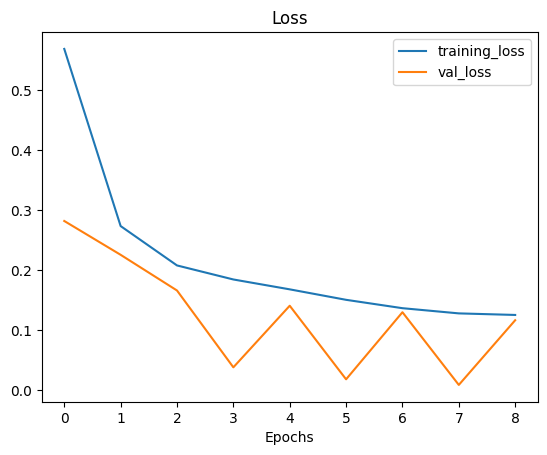

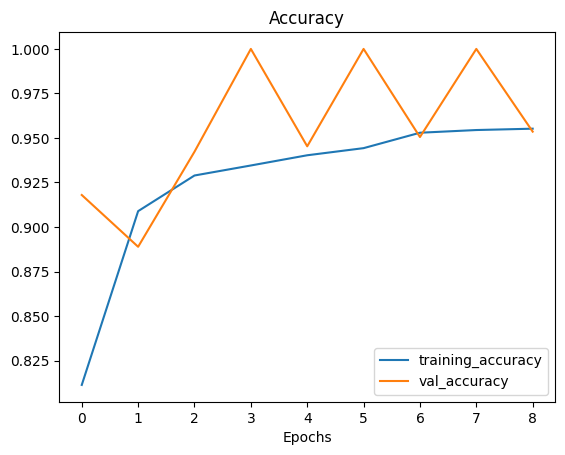

In [ ]:
plot_loss_curves(hist_4)

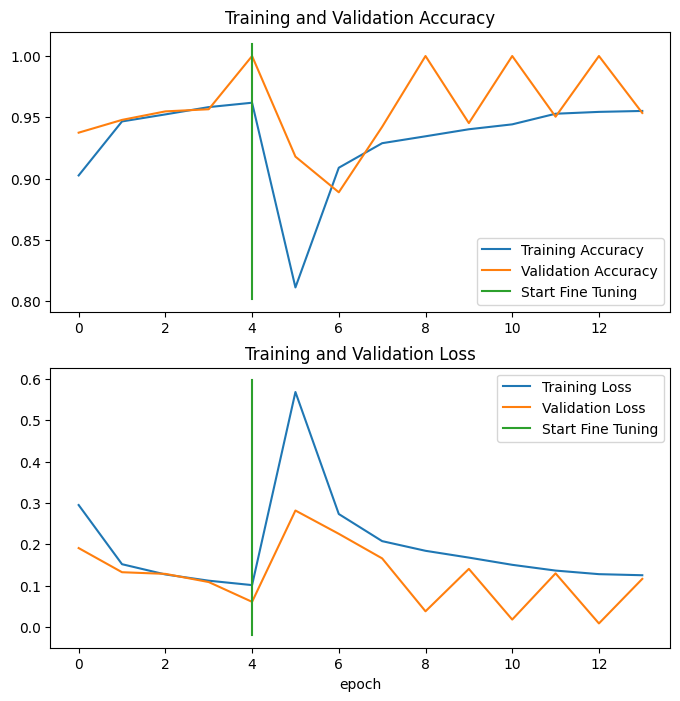

In [ ]:
compare_historys(hist_2, hist_4)

In [ ]:
model_4.evaluate(test_data)

73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9463 - loss: 0.1153


[0.11713789403438568, 0.9533073902130127]

In [ ]:
model.save(f'{save_pth}/crop_disease_efficientnet_finetuned_V2.keras')

## Result

From the experiments, the fine tuned feature extractor model without data augmentation works better, this will be our new base model which we will try to improve on in the future

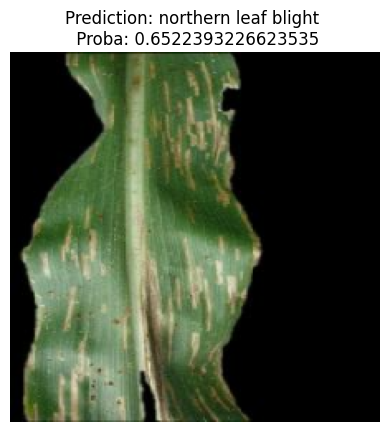

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt

model_3 = load_model('/content/drive/MyDrive/Crop Disease/crop_disease_efficientnet_finetuned_V1.keras')
def make_prediction(model, path):

    img = tf.io.read_file(path)

    # Decode the image into a tensor
    img = tf.image.decode_image(img, channels=3)  # Ensure 3 channels (RGB)

    # Resize the image to the expected input shape
    img = tf.image.resize(img, size=[224, 224])

    # Rescale the image to [0, 1]
    img_1 = img / 255.0

    # Expand dimensions to fit model input
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    preds = model.predict(img, verbose=0)

    # Print predictions for debugging
    # print("Predictions:", preds)

    # Get the class index with the highest probability
    predicted_class_index = tf.argmax(preds[0])

    plt.title(f"Prediction: {' '.join(train_data.class_names[predicted_class_index].split('___')[1].split('_'))} \n Proba: {preds[0][tf.argmax(preds[0])]}")
    plt.imshow(img_1)
    plt.axis('off')

img_path = '/content/Corn/test/'
img_type = random.choice(os.listdir(img_path))
new_img = os.path.join(img_path, img_type)
img = os.path.join(new_img, random.choice(os.listdir(new_img)))
# img = tf.io.read_file(img)

make_prediction(model_3, img)